<a href="https://colab.research.google.com/github/hxtruong/fb-developer-circles/blob/master/Porto_safe_driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Porto Seguro's Safe Driver Prediction
====

## Introduction
[This competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data) is hosted by the third largest insurance company in Brazil: Porto Seguro with the task of predicting the probability that a driver will initiate an insurance claim in the next year.

In the train data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. **Values of -1 indicate that the feature was missing** from the observation. The target columns signifies whether or not a claim was filed for that policy holder

train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.


In [0]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

# To avoid Warning message inbetween ...
import warnings
warnings.filterwarnings('ignore')

In [58]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [59]:
# Read csv file and take a look at it
train = pd.read_csv('gdrive/My Drive/Dataset/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [60]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {} rows and {} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

## 1. Data Quality Checks

### Null or missing values check
Let check whether there are any null values in the train dataset as follows:

In [62]:
train.isnull().any().any()

False

**Note:** Our null values check returns False but however, this does not really mean that this case has been closed as the data is also described as *"Values of -1 indicate that the feature was missing from the observation"*. Therefore I take it that Porto Seguro has simply conducted a blanket replacement of all null values in the data with the value of -1. Let us now inspect if there where any missing values in the data.

Here we can see that which columns contained -1 in their values so we could easily for example make a blanket replacement of all -1 with nulls first as follows:

In [0]:
train_copy = train.copy()
train_copy = train_copy.replace(-1, np.NaN)

We can use "Missingno" to visualize missing values in the dataset.

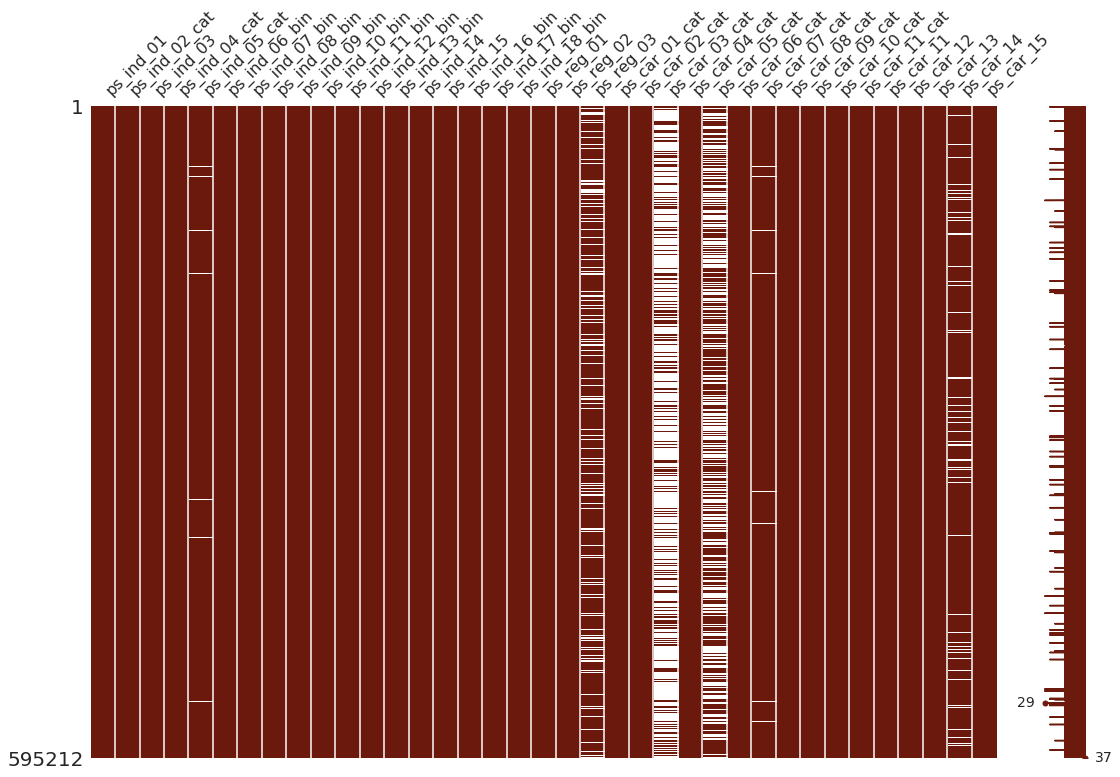

In [64]:
# If you don't have "Missingno" package, use this command to install
# (Linux) conda install -c conda-forge missingno
import missingno as msno

msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(18, 12), color=(0.42, 0.1, 0.05))

In [65]:
# List null columns name
# Hint: isnull()
nullCols = dict(train_copy.isnull().sum())
for k,v in nullCols.items():
  if v>0:
    print(str(k) + ': '+ str(v)) 

ps_ind_02_cat: 216
ps_ind_04_cat: 83
ps_ind_05_cat: 5809
ps_reg_03: 107772
ps_car_01_cat: 107
ps_car_02_cat: 5
ps_car_03_cat: 411231
ps_car_05_cat: 266551
ps_car_07_cat: 11489
ps_car_09_cat: 569
ps_car_11: 5
ps_car_12: 1
ps_car_14: 42620


#### Target variable inspection

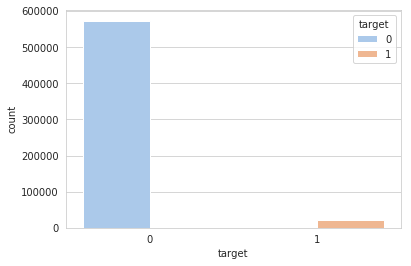

In [66]:
sns.countplot(x='target', hue='target', data=train, palette="pastel")

## 2. Feature inspection and filtering

### Correlation plots
As a starter, let us generate some linear correlation plots just to have a quick look at how a feature is linearly correlated to the next and perhaps start gaining some insights from here. At this juncture, I will use the seaborn statistical visualisation package to plot a heatmap of the correlation values. Conveniently, Pandas dataframes come with the corr() method inbuilt, which calculates the Pearson correlation. Also as convenient is Seaborn's way of invoking a correlation plot. Just literally the word "heatmap"

#### Correlation of float features

In [0]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

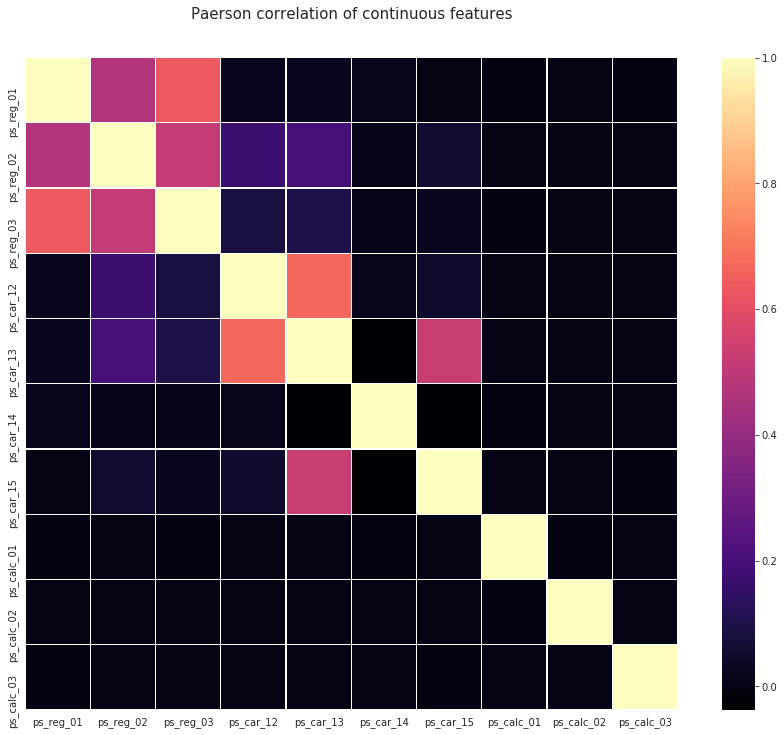

In [68]:
colormap = plt.cm.magma
plt.figure(figsize=(16, 12))
plt.title("Paerson correlation of continuous features", y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True,
           cmap=colormap)
plt.show()

From the correlation plot, we can see that the majority of the features display zero or no correlation to one another. This is quite an interesting observation that will warrant our further investigation later down. For now, the paired features that display a positive linear correlation are listed as follows:

(ps_reg_01, ps_reg_03)

(ps_reg_02, ps_reg_03)

(ps_car_12, ps_car_13)

(ps_car_13, ps_car_15)

### Correlation of integer features

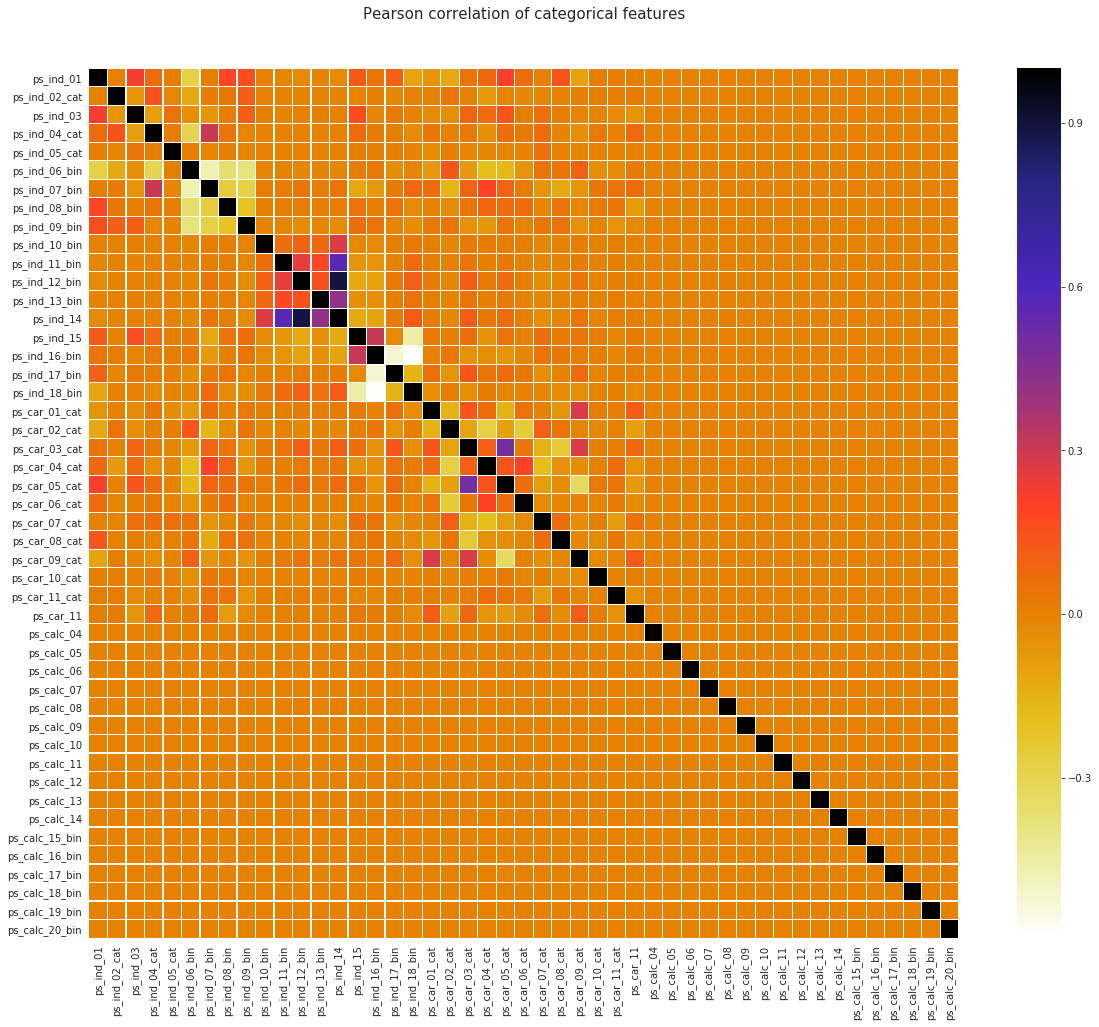

In [74]:
# Your code here
# Hint: correlation of train_int
train_int = train_int.drop(["id", "target"], axis=1)
colormap = plt.cm.CMRmap_r
plt.figure(figsize=(21,16))
plt.title('Pearson correlation of categorical features', y=1.05, size=15)
sns.heatmap(train_int.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, annot=False)
plt.show()

#### Which features have negatively correlation?
Negatively correlated features : ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

### Binary features inspection
Another aspect of the data that we may want to inspect would be the coulmns that only contain binary valeus, i.e where values take on only either of the two values 1 or 0. Proceeding, we store all columns that contain these binary values and then generate a vertical plotly bar plot of these binary values as follows:

In [0]:
bin_col = list(filter(lambda x: '_bin' in x, train.columns))
bin_value_counts = train[bin_col].apply(pd.value_counts)

In [76]:
bin_value_counts

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,360852,442223,497644,484917,594990,594205,589594,594648,201882,523143,503879,522342,221514,265356,424278,387469,503955
1,234360,152989,97568,110295,222,1007,5618,564,393330,72069,91333,72870,373698,329856,170934,207743,91257


In [0]:
# hint pandas plot.bar with stacked=True
# Your code here

Those columns ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin which are completely dominated by zeros. They do not contain much information.

## 3. Preprocess Data

In [0]:
# Import train_test_split 
# Your code here

In [0]:
# Define X (features), y (target)
X = # Your code here
y = # Your code here

In [0]:
# Split data into train and test set
X_train, X_test, y_train, y_test = # Your code here

#### Randomly Under-Sampling the Training Dataset¶
**Note:** Validate ratio between 2 class after Under-Sampling

In [0]:
# Your code here

#### Randomly Over-Sampling the Training Dataset
**Note:** Validate ratio between 2 class after Over-Sampling

In [0]:
# Your code here

## 4. Modeling

In [0]:
# Spot check with LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, BernoulliNB, GaussianNB
# Import libraries and and create model
# Your code here
lr = #Your code here
dtc = #Your code here
rfc = #Your code here
bnb = #Your code here
gnb = #Your code here

models = [lr, dtc, rfc, gnb, bnb]
models_name = ["Logistic Regression", "Decision Tree", "Random Forest", "Bernoulli NB", "Gaussian NB"]

## 5. Evaluation Metrics

In [0]:
# Import confusion_matrix, classification_report
# Your code here

# We create an utils function, that take a trained model as argument and print out confusion matrix
# classification report base on X and y
def evaluate_model(estimator, X, y):
    # Your code here
    return 0

### Evaluate with Origin dataset

In [0]:
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Origin dataset
    
    # Evaluate model with X_test, y_test
    print("=======================================")

### Evaluate with *Undersampled* dataset

In [0]:
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Undersampled dataset
    
    # Evaluate model with X_test, y_test
    print("=======================================")

### Evaluate with *Oversampled* dataset

In [0]:
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Oversampled dataset
    
    # Evaluate model with X_test, y_test
    print("=======================================")

### Conclusion

Which model has lowest/highest accuracy?
Which model has lowest/highest recall?
Which model has lowest/highest f1?

## 6. GridsearchCV

In [0]:
# Using gridsearchcv, random forest model and this param grid to find the best combination of parameters 
# Hint: example
# https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}



#### which is the best combination of parameter

In [0]:
# Your code here

# Done! Great Job.